# Introduction to Monte Carlo Simulation in Finance

## Example: A Crude Simulation of a Call Option Price under the Black-Scholes Model

Ref.: *Don L. McLeish* **Monte Carlo Simulation and Finance** Wiley

<img src="img/cover_mcleish.jpg" width="10%" align="left" border="0">

In [1]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl


It's worth to recast the pricing problem into a simple integral formulation in order to gain some insight into the general problem;
\item So let's consider again the payoff of a simple plain vanilla option
$$e^{-rT} \mathbb{E^Q} [ h(S_T) ] = e^{-rT} \mathbb{E^Q} \left[ h \left( S_0 e^{\log(S_T/S_0)} \right) \right]$$

By a simple application of Ito's lemma is easy to demonstrate that the variable $X = \log(S_T/S_0)$ has a normal distribution with mean $m=(r-\frac{1}{2} \sigma^2)T$ and variance $s=\sigma^2T$.

So we can write
$$ C(S,t)= e^{-rT}\int\limits_{-\infty}^{+\infty} \max[S_0e^X-K,0] e^{-\frac{(X-m)^2}{2s^2}} dX  $$

It is possible to generate a normally distributed random variable $X=\Phi^{-1}(U;(r-\frac{1}{2} \sigma^2)T;\sigma^2T)$ using the inverse transform method, where $\Phi^{-1}(U;(r-\frac{1}{2} \sigma^2)T;\sigma^2T)$ is the inverse of the normal cumulative distribution function evaluated at $U$, a uniform $[0,1]$ random variable.

$$U = \Phi[X;m,u], \quad u\rightarrow 1 \, when \, X \rightarrow +\infty, \quad u\rightarrow 0 \, when \, X \rightarrow -\infty$$

has a uniform distribution;

From the previous relation we find (within a normalization factor)

$$du = \frac{d\Phi[X;m,u]}{dX} dX  \Rightarrow dX = \frac{1}{e^{-\frac{(X-m)^2}{2s^2}}}du$$

Then the value of the option can be written as an expectation over the distribution of the uniform random variabile $U$:

$$
C(S,t) = \int\limits_0^1 f(u) du$$
where $f(u) = e^{-rT} \max[S_0 \exp(\Phi^{-1}(u; m,s)) - K,0] $

In [2]:
def f(u, S0, K, r, sigma, T):
    m      = (r - .5*sigma*sigma)*T
    s      = sigma*sqrt(T)
    f_u    = exp(-r*T)*np.maximum(S0*exp(scnorm.ppf(u, m, s))-K,0)
    return f_u
    #
    # this is the same code in R language
    #
    #x = S0*exp(qnorm(u,mean=r*T-sigma^2*T/2,sd=sigma*sqrt(T)))
    #v = exp(-r*T) * pmax((x-K),0)

where scnorm.ppf is the [inverse of cumulative normal](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.norm.html)

We recall the Black and Scholes formulas from the pricing of Call and Put Options...

$C(S(t)) = S(t)N(d_1)-Ke^{-r(T-t)}N(d_2)$

$P(S(t)) = Ke^{-r(T-t)}N(-d_2) - S(t)N(-d_1)$

where

$d_1=\frac{\log(S(t)/K)+(r+\sigma^2/2}{\sigma \sqrt{T}}$ 

$d_2 = d_1 - \sigma \sqrt{T}$

In [3]:
import numpy as np
import scipy.stats as ss
import time 

#Black and Scholes
def d1(S0, K, r, sigma, T):
    return (np.log(S0/float(K)) + (r + sigma**2 / 2.0) * T)/ float(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0/float(K)) + (r - sigma**2 / 2.0) * T) / float(sigma * np.sqrt(T))
 
def BlackScholes(payoff, S0, K, r, sigma, T):
    if payoff == 1:
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T))


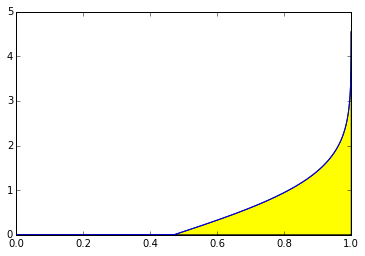

In [4]:
S0     = 10
K      = 10
r      = 0.05
T      = 0.25
sigma  = 0.2

u      = np.linspace(0, 1, 10000)
f_u    = f(u,S0,K,r,sigma,T)

pl.plot(u, f_u)
pl.fill_between(u, f_u, facecolor='yellow', interpolate=True)
pl.show()


### Crude Montecarlo

In [5]:

u      = rand(500000)
f_u    = f(u,S0,K,r,sigma,T)
mc     = np.mean(f_u)
sf     = sqrt(np.var(f_u))
se     = sf/sqrt(len(u))
bs     = BlackScholes(1,S0,K,r,sigma, T)
delta  = abs(mc-bs)

print 'Montecarlo estimate : %f'%mc
print 'Analytical result   : %f'%bs
print 'Difference          : %f'%delta
print 'Sample Standard Dev : %f'%sf
print 'Standard Error      : %f'%se

Montecarlo estimate : 0.461145
Analytical result   : 0.461500
Difference          : 0.000355
Sample Standard Dev : 0.660158
Standard Error      : 0.000934


### Antithetic Random Numbers

In [6]:
u      = rand(1000000)
f_u    = f(u,S0,K,r,sigma,T)
mc     = np.mean(f_u)
sf     = sqrt(np.var(f_u))
var_cm = np.var(f_u)
se_cm  = sf/sqrt(len(u))
bs     = BlackScholes(1,S0,K,r,sigma, T)

print 'Montecarlo estimate : %f'%mc
print 'Analytical result   : %f'%bs
print 'Sample Standard Dev : %f'%sf
print 'Sample Variance     : %f'%var_cm
print 'Standard Error      : %f'%se_cm

Montecarlo estimate : 0.461741
Analytical result   : 0.461500
Sample Standard Dev : 0.660032
Sample Variance     : 0.435642
Standard Error      : 0.000660


In [7]:
u      = rand(500000)
f_u    = .5*(f(u,S0,K,r,sigma,T) + f(1-u,S0,K,r,sigma,T))
mc     = mean(f_u)
sf     = sqrt(np.var(f_u))
var_an = np.var(f_u)
se     = sf/sqrt(len(u))
bs     = BlackScholes(1,S0,K,r,sigma, T)

print 'Montecarlo estimate : %f'%mc
print 'Analytical result   : %f'%bs
print 'Sample Standard Dev : %f'%sf
print 'Sample Variance     : %f'%var_an
print 'Standard Error      : %f'%se

print 'Efficiency Gain     : %f'%(var_cm/var_an)

Montecarlo estimate : 0.461194
Analytical result   : 0.461500
Sample Standard Dev : 0.333923
Sample Variance     : 0.111505
Standard Error      : 0.000472
Efficiency Gain     : 3.906936


### Stratified Sampling

In [8]:
a      = 0.7
f_u    = a*f(a*u,S0,K,r,sigma,T) + (1-a)*f(a+(1-a)*u,S0,K,r,sigma,T) 
mc     = mean(f_u)
sf     = sqrt(np.var(f_u))
var    = np.var(f_u)
se     = sf/sqrt(len(u))
bs     = BlackScholes(1,S0,K,r,sigma, T)

print 'Montecarlo estimate : %f'%mc
print 'Analytical result   : %f'%bs
print 'Sample Standard Dev : %f'%sf
print 'Sample Variance     : %f'%var
print 'Standard Error      : %f'%se

print 'Efficiency Gain     : %f'%(var_cm/var)

Montecarlo estimate : 0.462024
Analytical result   : 0.461500
Sample Standard Dev : 0.292176
Sample Variance     : 0.085367
Standard Error      : 0.000413
Efficiency Gain     : 5.103191


### Control Variates

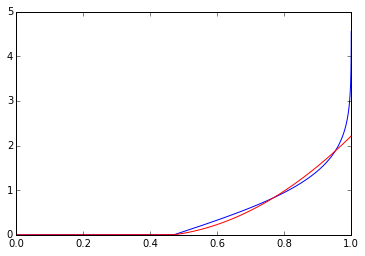

In [9]:
def g(u):
    return 6*(np.maximum(u-0.47,0))**2 + np.maximum(u-0.47,0)


S0     = 10
K      = 10
r      = 0.05
T      = 0.25
sigma  = 0.2

u      = np.linspace(0, 1, 10000)
f_u    = f(u,S0,K,r,sigma,T)
g_u    = g(u)
plot(u, f_u)
plot(u, g_u, color='red')
pl.show()


In [10]:
u      = rand(500000)
f_u    = f(u,S0,K,r,sigma,T)
g_u    = g(u)
intg   = 2*(0.53)**3 + 0.5*(0.53)**2
mc     = intg + np.mean(f_u - g_u)
var_1  = np.var(f_u)
var_2  = np.var(f_u-g_u)
bs     = BlackScholes(1,S0,K,r,sigma, T)

print 'Montecarlo estimate : %f'%mc
print 'Analytical result   : %f'%bs
print 'Efficiency gain     : %f'%(var_1/var_2)

Montecarlo estimate : 0.461751
Analytical result   : 0.461500
Efficiency gain     : 30.011948
